In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


from classes import *
from functions import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetCNN().to(device)


model.load_state_dict(torch.load('best_model.pt', map_location=device))

model.eval()

PetCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_featu

In [2]:

base_dir = '/Users/hunte/Desktop/PetImages'

dog_files,cat_files = gather_paths(base_dir)

train_files, train_labels, val_files, val_labels = create_train_val_split(dog_files, cat_files, val_size=0.2)

# Data Augmentation and Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.7, 1.3)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Datasets and DataLoaders (see classes.py for PetDataset class)
train_dataset = PetDataset(train_files, train_labels, transform=train_transforms)
val_dataset = PetDataset(val_files, val_labels, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


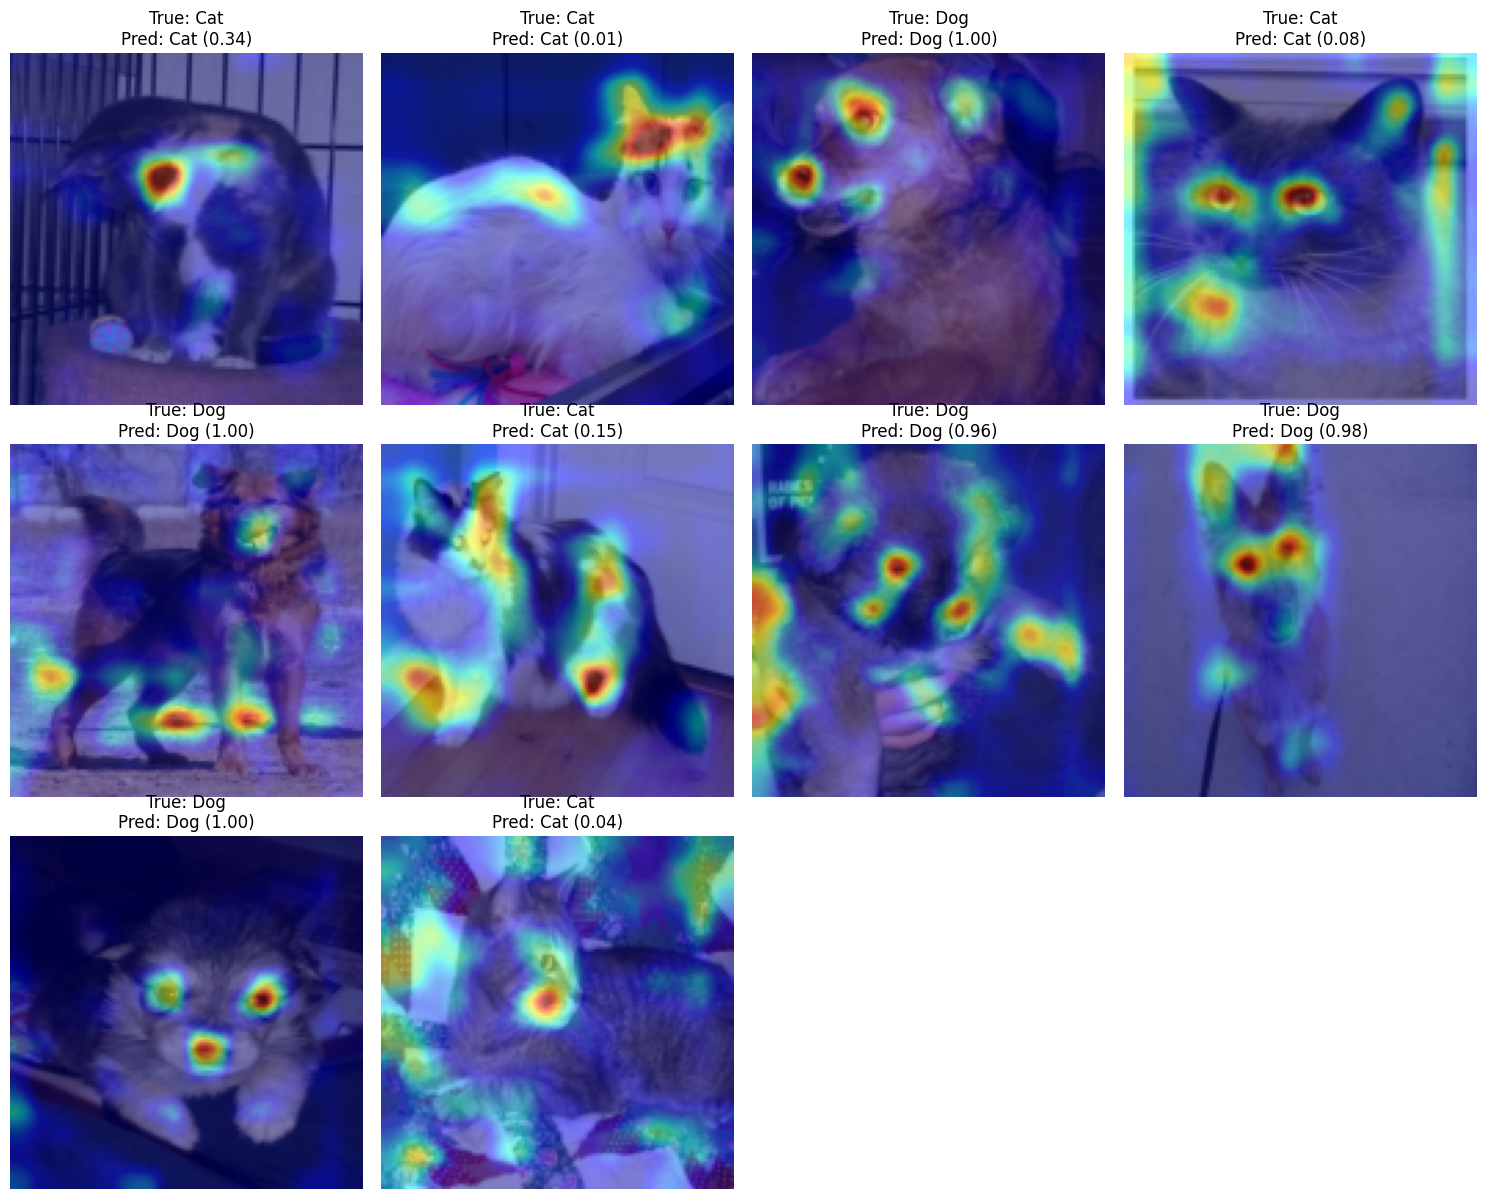

In [6]:
import torch
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import random

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

cam_extractor = GradCAM(model, target_layer='conv4')

# Collect samples from the validation set
samples = []
for inputs, labels in val_loader:
    for img, label in zip(inputs, labels):
        samples.append((img, label.item()))

# Randomly select 10 samples
random_samples = random.sample(samples, 10)

plt.figure(figsize=(15, 12))

for idx, (img, label) in enumerate(random_samples):
    input_img = img.unsqueeze(0).to(device)
    
    # Forward pass
    output = model(input_img)
    probability = output.item()
    predicted_label = 'Dog' if probability > 0.5 else 'Cat'
    true_label = 'Dog' if label == 1 else 'Cat'

    # Extract CAM
    activation_map = cam_extractor(class_idx=0, scores=output)

    # Prepare the image for visualization
    img_denorm = img.cpu() * 0.5 + 0.5
    img_pil = to_pil_image(img_denorm)

    # Normalize activation map
    heatmap = activation_map[0].cpu()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap_pil = to_pil_image(heatmap, mode='F')

    # Overlay CAM onto original image
    result = overlay_mask(img_pil, heatmap_pil, alpha=0.5)

    # Plot
    plt.subplot(3, 4, idx + 1)
    plt.imshow(result)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPred: {predicted_label} ({probability:.2f})')

plt.tight_layout()
plt.show()

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Instantiate a fresh model and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetCNN().to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()

# Accuracy evaluation without hooks (GradCAM-free)
correct_cats = 0
correct_dogs = 0
total_cats = 0
total_dogs = 0

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).squeeze()
        predictions = (outputs >= 0.5).int()

        for pred, true_label in zip(predictions, labels):
            if true_label.item() == 0:
                total_cats += 1
                if pred.item() == 0:
                    correct_cats += 1
            else:
                total_dogs += 1
                if pred.item() == 1:
                    correct_dogs += 1

print(f"Cat accuracy: {correct_cats}/{total_cats} ({(correct_cats/total_cats)*100:.2f}%)")
print(f"Dog accuracy: {correct_dogs}/{total_dogs} ({(correct_dogs/total_dogs)*100:.2f}%)")

Evaluating: 100%|██████████| 157/157 [00:08<00:00, 18.09it/s]

Cat accuracy: 2196/2500 (87.84%)
Dog accuracy: 2424/2500 (96.96%)


In [ ]:
# Load original PetCNN
model_petcnn = PetCNN().to(device)
model_petcnn.load_state_dict(torch.load('best_model.pt'))
model_petcnn.eval()

# Load SmallPetCNN
model_smallpetcnn = SmallerPetCNN().to(device)
model_smallpetcnn.load_state_dict(torch.load('smaller_best_model.pt'))
model_smallpetcnn.eval()

def evaluate_ensemble(model1, model2, val_loader):
    cat_correct, dog_correct, total_cat, total_dog = 0, 0, 0, 0
    
    val_bar = tqdm(val_loader, desc="Evaluating Ensemble")
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            # Get guesses from both models
            outputs1 = model1(inputs).squeeze()  # PetCNN
            outputs2 = model2(inputs).squeeze()  # SmallPetCNN
            
            # Average the guesses
            outputs_avg = (outputs1 + outputs2) / 2
            predicted = (outputs_avg >= 0.5).float()
            
            # Count correct guesses for cats (label 0) and dogs (label 1)
            for i in range(labels.size(0)):
                if labels[i] == 0:  # Cat
                    total_cat += 1
                    if predicted[i] == 0:
                        cat_correct += 1
                else:  # Dog
                    total_dog += 1
                    if predicted[i] == 1:
                        dog_correct += 1
    
    cat_acc = cat_correct / total_cat if total_cat > 0 else 0
    dog_acc = dog_correct / total_dog if total_dog > 0 else 0
    overall_acc = (cat_correct + dog_correct) / (total_cat + total_dog)
    
    print(f"Cat accuracy: {cat_correct}/{total_cat} ({cat_acc*100:.2f}%)")
    print(f"Dog accuracy: {dog_correct}/{total_dog} ({dog_acc*100:.2f}%)")
    print(f"Overall accuracy: {(cat_correct + dog_correct)}/{(total_cat + total_dog)} ({overall_acc*100:.2f}%)")
    
    return cat_acc, dog_acc, overall_acc

# Run it
cat_acc, dog_acc, overall_acc = evaluate_ensemble(model_petcnn, model_smallpetcnn, val_loader)


Evaluating Ensemble: 100%|██████████| 157/157 [00:09<00:00, 16.01it/s]

Cat accuracy: 2311/2500 (92.44%)
Dog accuracy: 2420/2500 (96.80%)
Overall accuracy: 4731/5000 (94.62%)
